# Correlation Between Timelags and Field Strengths
Look at magnetic field strength in each pixel and compute regression between timelag for all channel pairs. Do this for all heating models as well as observations. What do we find?

In [93]:
import numpy as np
from scipy.interpolate import splev,splprep,splrep
from scipy.optimize import curve_fit
import matplotlib
import matplotlib.pyplot as plt
from sunpy.map import Map,GenericMap
from sunpy.coordinates import HeliographicStonyhurst
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar
from sklearn.preprocessing import scale,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from distributed import Client
#from dask_ml.model_selection import GridSearchCV

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA
from synthesizAR.util import is_visible

%matplotlib inline

## Prep and Clean Data

### Magnetic Field
This first thing we want to do is to compute the average field strength in each pixel. We'll interpolate the field strength in each loop to a reasonable resolution and then bin it over the map.

In [2]:
field = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/base_noaa1158/')

In [3]:
ds = 0.5*u.Mm
stacked_coords = None
stacked_bmag = None
for loop in field.loops:
    knots, _ = splprep(loop.coordinates.cartesian.xyz.value)
    n_interp = int(np.ceil((loop.full_length/ds).decompose()))
    tmp = np.array(splev(np.linspace(0, 1, n_interp), knots))
    tmp_bmag = splev(np.linspace(loop.field_aligned_coordinate.value[0], loop.field_aligned_coordinate.value[-1], n_interp),
                     splrep(loop.field_aligned_coordinate.value, loop.field_strength.mean().value*np.ones(loop.field_strength.shape)))
    if stacked_coords is None:
        stacked_coords = tmp
    else:
        stacked_coords = np.hstack([stacked_coords, tmp])
    if stacked_bmag is None:
        stacked_bmag = tmp_bmag
    else:
        stacked_bmag = np.hstack([stacked_bmag, tmp_bmag])
stacked_coords = u.Quantity(stacked_coords, loop.coordinates.cartesian.xyz.unit)
stacked_bmag = u.Quantity(stacked_bmag, loop.field_strength.unit)
stacked_coords = SkyCoord(x=stacked_coords[0,:],y=stacked_coords[1,:],z=stacked_coords[2,:],frame=HeliographicStonyhurst,representation='cartesian')
stacked_coords = stacked_coords.transform_to(HeliographicStonyhurst).transform_to(field.magnetogram.coordinate_frame)

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:299: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/mapbase.py:669: Warning: Missing metadata for heliographic longitude: assuming longitude of 0 degrees
  lon=self.heliographic_longitude,


In [4]:
class FakeAIA(InstrumentSDOAIA):
    @property
    def total_coordinates(self):
        return stacked_coords
aia = FakeAIA([0,1]*u.s,field.magnetogram.observer_coordinate)
bins,bin_range = aia.make_detector_array(field)
meta = aia.make_fits_header(field,{})
visible = is_visible(aia.total_coordinates, aia.observer_coordinate)
hist_coordinates, _, _ = np.histogram2d(aia.total_coordinates.Tx.value, aia.total_coordinates.Ty.value,
                                        bins=(bins.x.value, bins.y.value), range=(bin_range.x.value, bin_range.y.value),
                                        weights=visible)
hist, _, _ = np.histogram2d(aia.total_coordinates.Tx.value,aia.total_coordinates.Ty.value,
                            bins=(bins.x.value, bins.y.value),range=(bin_range.x.value, bin_range.y.value),
                            weights=stacked_bmag.value * visible)
hist /= np.where(hist_coordinates == 0, 1, hist_coordinates)
meta['bunit'] = stacked_bmag.unit.to_string()
bmag_map = GenericMap(hist.T, meta)

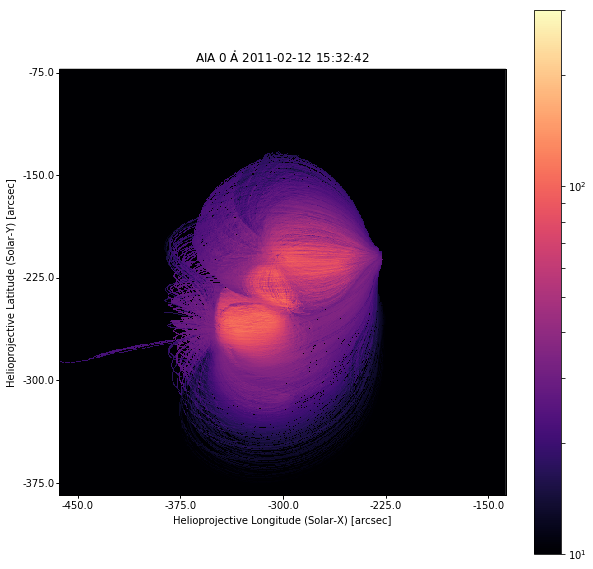

In [5]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=bmag_map)
bmag_map.plot(axes=ax,cmap='magma',norm=matplotlib.colors.SymLogNorm(1e-10,vmin=10,vmax=300))
ax.grid(alpha=0)
plt.colorbar()

### Timelags
Import timelags for all channel pairs and split into separate datasets for each heating frequency.

In [6]:
channel_pairs = [(94,335),(94,171),(94,193),(94,131),(94,211),
                 (335,131),(335,193),(335,211),(335,171),
                 (211,131),(211,171),(211,193),(193,171),(193,131),(171,131),]
frequencies = ['high', 'intermediate', 'low']
filename = '/storage-home/w/wtb2/data/timelag_synthesis_v2/{frequency}_frequency/nei/timelags/{type}_{c0}_{c1}.fits'
timelag,correlation = {}, {}
for f in frequencies:
    timelag[f'{f}'] = {}
    correlation[f'{f}'] = {}
    for p in channel_pairs:
        timelag[f'{f}']['{}_{}'.format(*p)] = Map(filename.format(frequency=f, type='timelag', c0=p[0], c1=p[1]))
        correlation[f'{f}']['{}_{}'.format(*p)] = Map(filename.format(frequency=f, type='correlation', c0=p[0], c1=p[1]))

In [7]:
X,Y = {},{}
correlation_threshold = 500.0
for f in frequencies:
    # Find the indices where all channel pairs have an acceptable correlation
    acceptable = np.all(np.stack([correlation[f]['{}_{}'.format(*p)].data for p in channel_pairs], axis=2) > correlation_threshold,axis=2)
    i_accept = np.where(acceptable)
    Y[f] = bmag_map.data[i_accept].flatten()
    X_tmp = None
    for p in channel_pairs:
        # Read in timelags and correlations
        tmp_tl = timelag[f]['{}_{}'.format(*p)].data
        # Only keep those timelags with sufficiently high correlations
        tmp_tl = tmp_tl[i_accept].flatten()
        # Stack along columns for different channel pairs
        X_tmp = tmp_tl.copy()[:,np.newaxis] if X_tmp is None else np.hstack([X_tmp, tmp_tl[:, np.newaxis]])
    # Stack along rows for different frequencies
    X[f] = X_tmp.copy()

## Peek at Data

In [96]:
popt

array([1., 1.])

(5, 100)

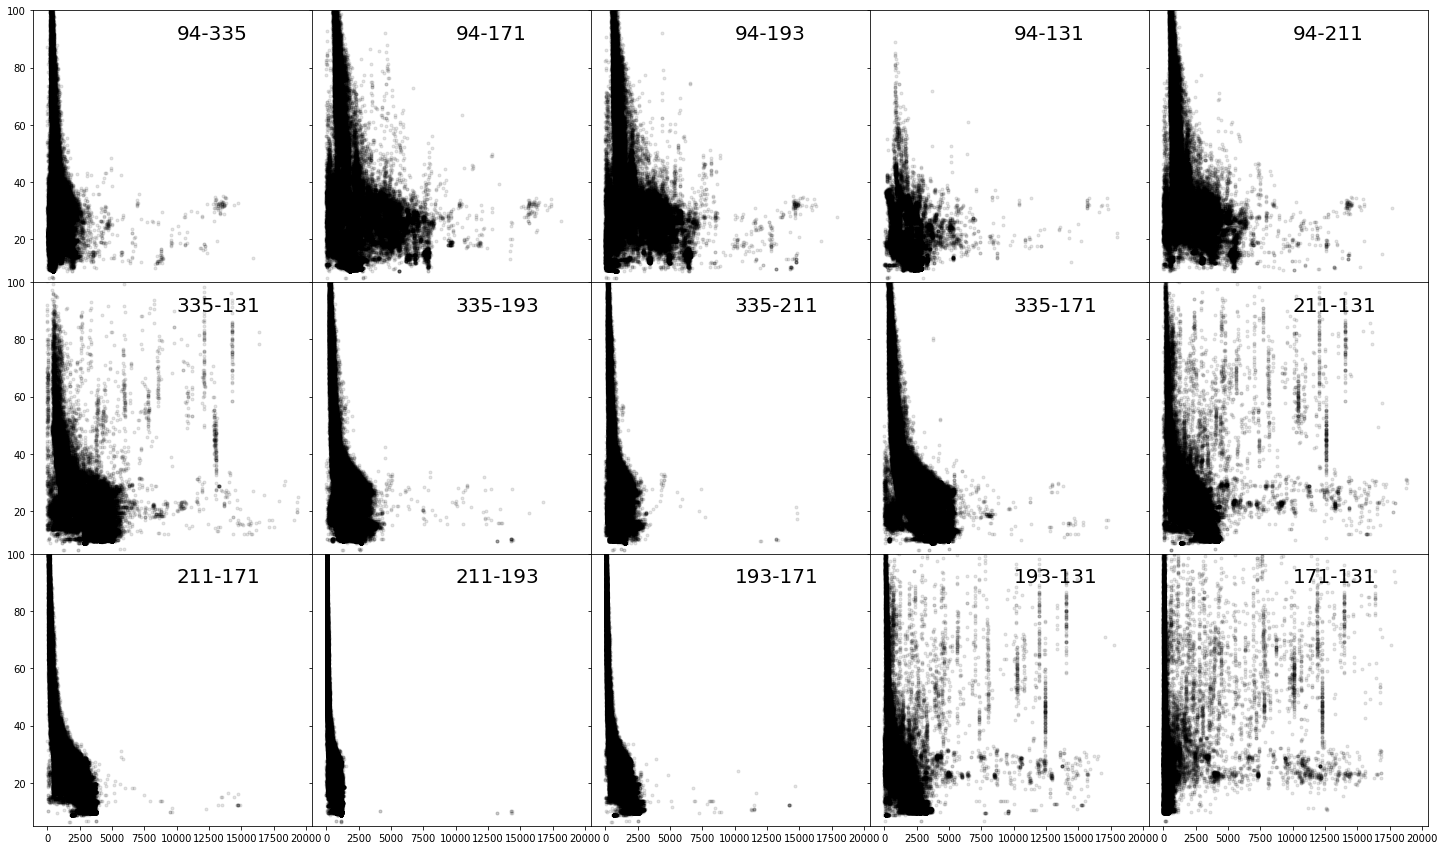

In [97]:
def exp_func(x,a,b):
    return a*np.exp(b*x)
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,cp in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    i_bnonzero = np.where(Y['high'] > 0)
    x = X['low'][:,i].copy()
    y = Y['low'].copy()
    y = y[np.where(x > 0)]
    x = x[np.where(x > 0)]
    x = x[np.where(y > 0)]
    y = y[np.where(y > 0)]
    ax.scatter(x,y,alpha=0.1,color='k',marker='.')
    #reg = make_pipeline(PolynomialFeatures(degree=3),LinearRegression())
    #reg.fit(x[:,np.newaxis],y)
    #popt,pcov = curve_fit(exp_func,np.sort(x),y[np.argsort(x)],)
    #y_p = exp_func(np.sort(x),*popt)#reg.predict(np.sort(x,)[:,np.newaxis]) #reg.coef_*np.sort(x)+ reg.intercept_
    #ax.plot(np.sort(x,),y_p,color='C3',lw=2)
    ax.text(10000,90,'{}-{}'.format(*cp),fontsize=20)
    #ax.text(4000,80,f'{reg.coef_[0]:.3f}')
#ax.set_xlim(-100,5e3)
ax.set_ylim(5,100)
#ax.set_yscale('log')

## Apply Regression

### High

In [46]:
X_scaled = scale(X['high'], axis=0, with_mean=True, with_std=True,)
Y_scaled = scale(Y['high'], axis=0, with_mean=True, with_std=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33)

#### Linear Regression

In [47]:
reg = LinearRegression()
reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
Y_pred = reg.predict(X_test)

In [49]:
print(f'The r^2 score is {r2_score(Y_test,Y_pred)}')
print(f'The MSE is {mean_squared_error(Y_test,Y_pred)}')

The r^2 score is 0.07840285326457652
The MSE is 0.9274867245539543


(-1, 3)

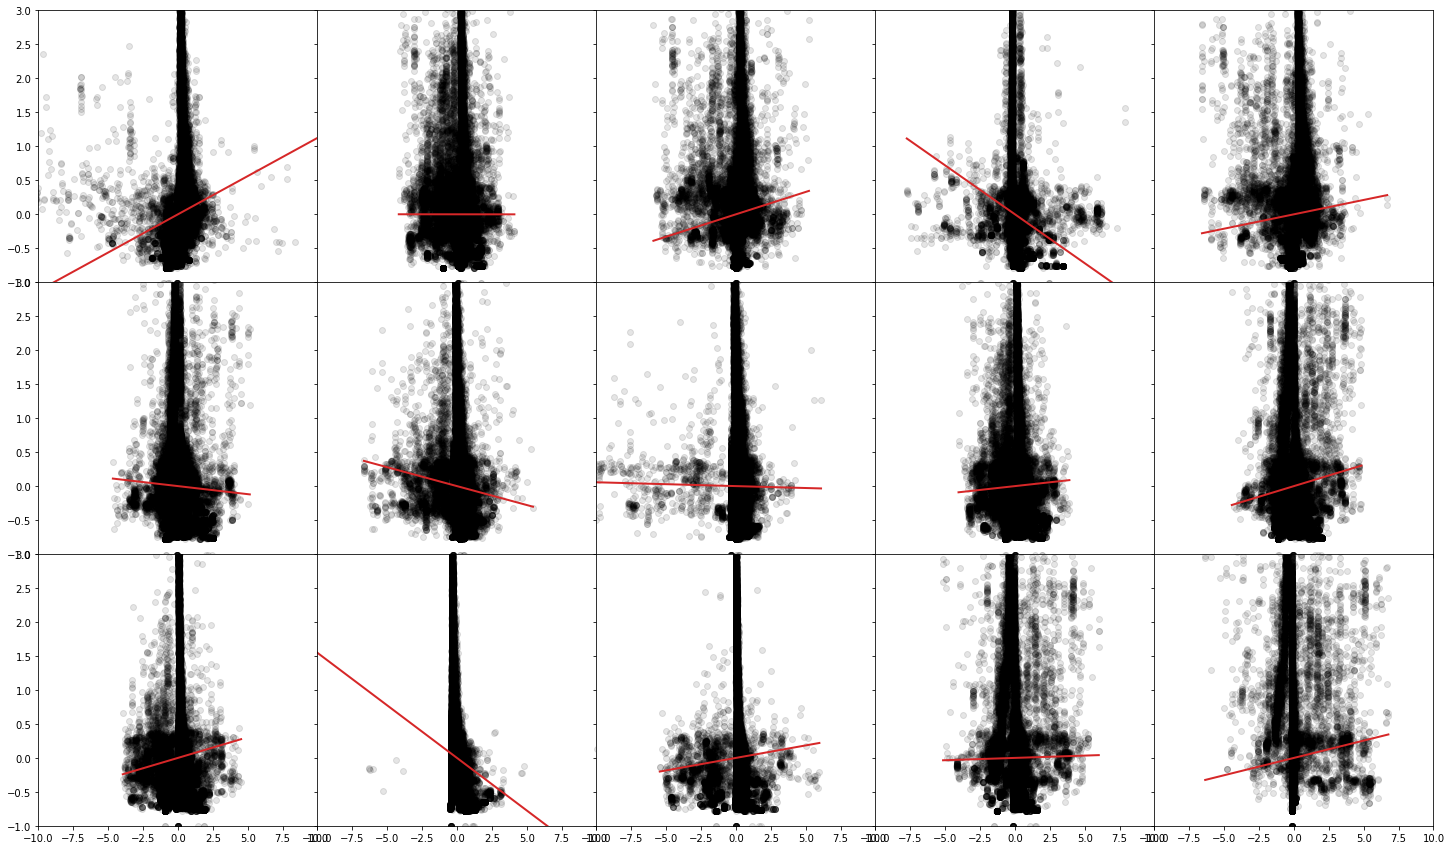

In [52]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,cp in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    r2 = r2_score(Y_test,Y_pred)
    ax.scatter(X_test[:,i], Y_test[:],alpha=0.1,color='k')
    #ax.plot(np.sort(X_test[:,i],),Y_pred[np.argsort(X_test[:,i])],alpha=0.1,color='C0',marker='+',)
    x_ordered = np.sort(X_test[:,i])
    ax.plot(x_ordered,reg.coef_[i]*x_ordered + reg.intercept_,color='C3',lw=2)
    #ax.text(-9,2.8,'{}-{}'.format(*cp))
    #ax.text(7,2.8,f'{reg.coef_[i]:.3f}')
ax.set_xlim(-10,10)
ax.set_ylim(-1,3)

Text(7,2.8,'-0.347')

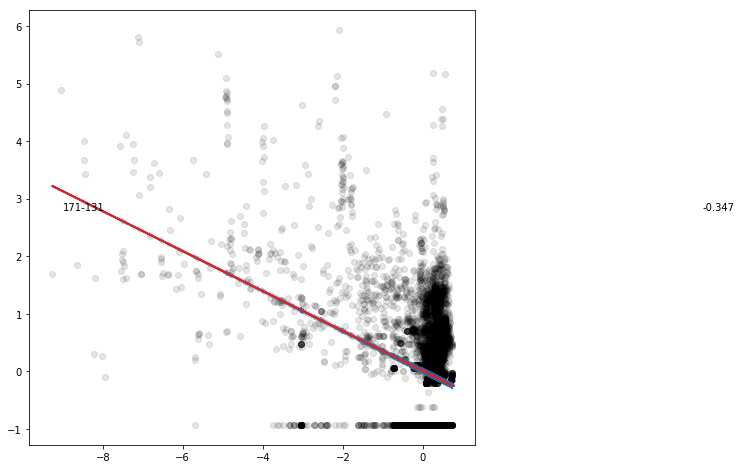

In [39]:
xgt0 = X['high'][:,0]
ygt0 = Y['high'][xgt0 < 0]
xgt0 = xgt0[xgt0<0]
xgt0 = xgt0[:,np.newaxis]
X_scaled = scale(xgt0, axis=0, with_mean=True, with_std=True,)
Y_scaled = scale(ygt0, axis=0, with_mean=True, with_std=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33)
reg = LinearRegression()
reg.fit(X_train,Y_train)
Y_pred = reg.predict(X_test)
fig = plt.figure(figsize=(8,8),)
ax = fig.gca()
ax.scatter(X_test, Y_test,alpha=0.1,color='k')
ax.scatter(X_test,Y_pred,alpha=0.1,color='C0',marker='+',)
x_ordered = np.sort(X_test)
ax.plot(x_ordered,reg.coef_*x_ordered + reg.intercept_,color='C3',lw=2)
ax.text(-9,2.8,'{}-{}'.format(*cp))
ax.text(7,2.8,f'{reg.coef_[0]:.3f}')
#ax.set_xlim(-10,10)
#ax.set_ylim(-1,3)

#### Support Vector Machines with a Non-linear Kernel

In [ ]:
reg = SVR(kernel='rbf',C=1e3,gamma=0.1)
reg.fit(X_train,Y_train)

In [122]:
Y_pred = reg.predict(np.sort(X_test,axis=0))

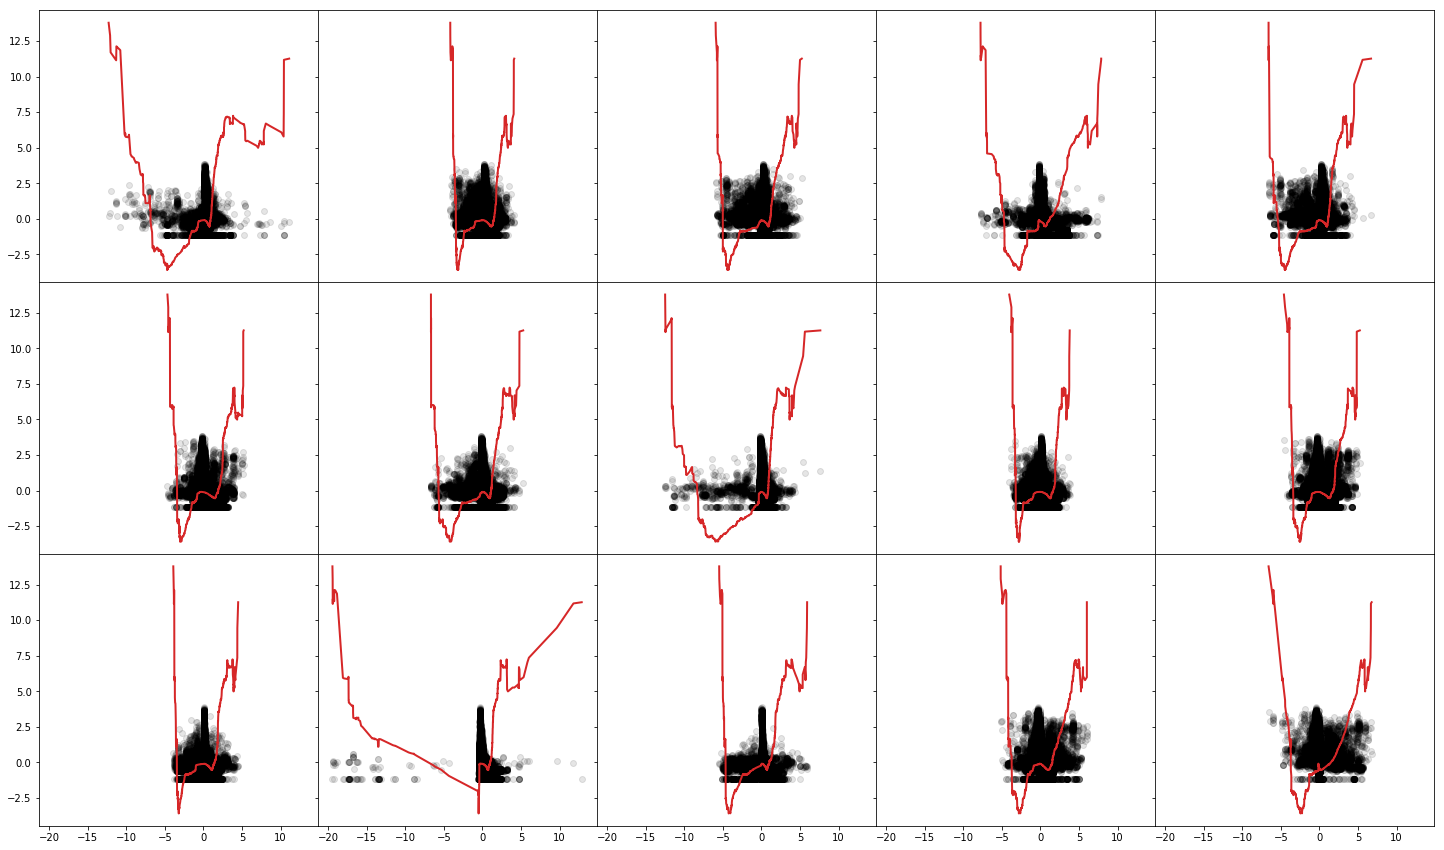

In [124]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,cp in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    r2 = r2_score(Y_test,Y_pred)
    ax.scatter(X_test[:,i], Y_test[:],alpha=0.1,color='k')
    #ax.scatter(X_test[:,i],Y_pred,alpha=0.1,color='C0',marker='+',)
    ax.plot(np.sort(X_test[:,i],axis=0),Y_pred,color='C3',lw=2)
    #ax.text(-9,2.8,'{}-{}'.format(*cp))
    #ax.text(7,2.8,f'{reg.coef_[i]:.3f}')
#ax.set_xlim(-10,10)
#ax.set_ylim(-1,3)

### Intermediate

In [103]:
X_scaled = scale(X['intermediate'], axis=0, with_mean=True, with_std=True,)
Y_scaled = scale(Y['intermediate'], axis=0, with_mean=True, with_std=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33)

#### Linear Regression

In [104]:
reg = LinearRegression()
reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [105]:
Y_pred = reg.predict(X_test)

In [106]:
print(f'The r^2 score is {r2_score(Y_test,Y_pred)}')
print(f'The MSE is {mean_squared_error(Y_test,Y_pred)}')

The r^2 score is 0.09132229339763209
The MSE is 0.9180658578825986


(-1, 3)

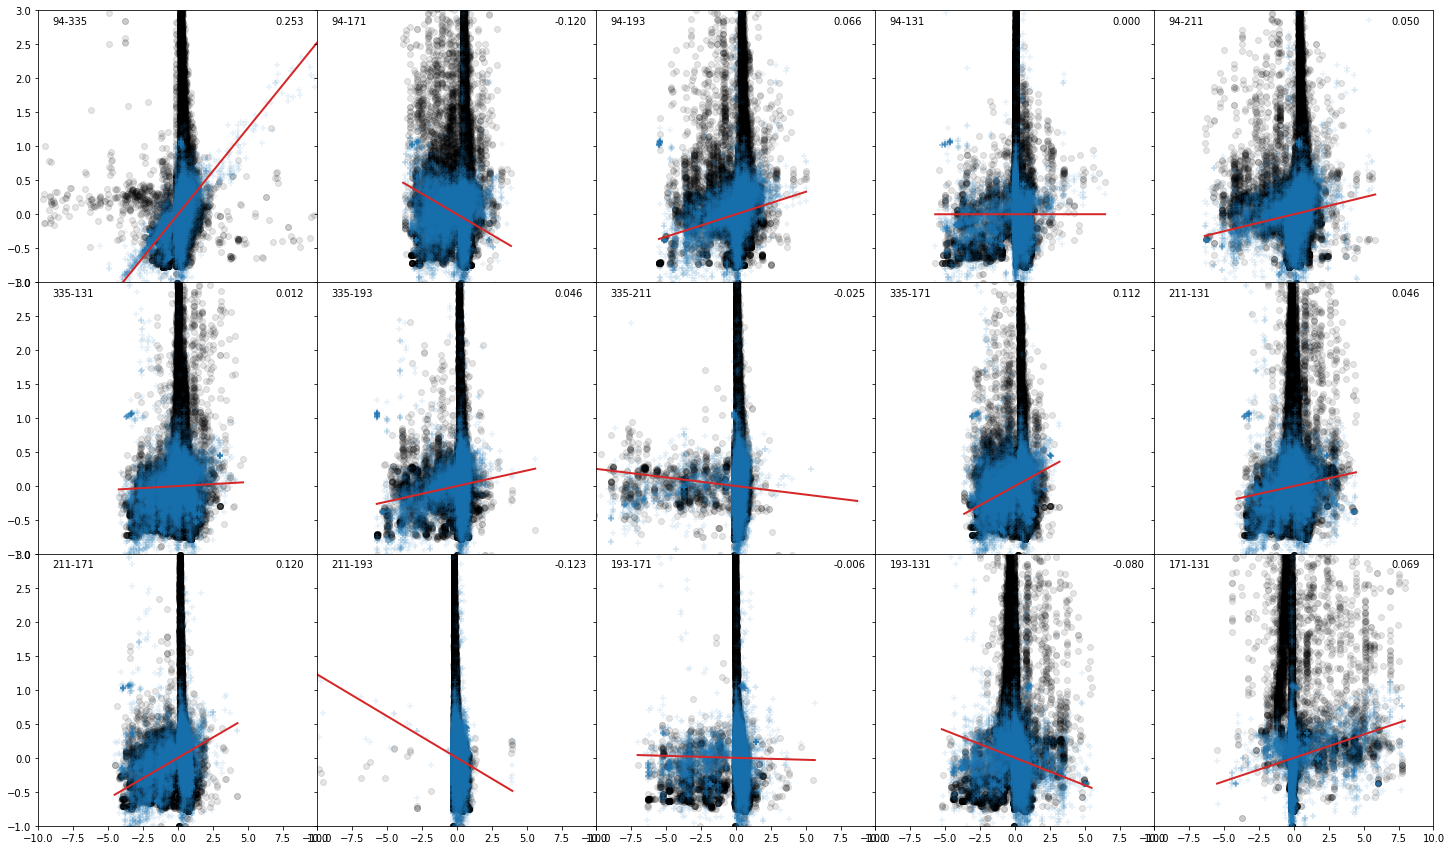

In [107]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,cp in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    r2 = r2_score(Y_test,Y_pred)
    ax.scatter(X_test[:,i], Y_test[:],alpha=0.1,color='k')
    ax.scatter(X_test[:,i],Y_pred,alpha=0.1,color='C0',marker='+',)
    x_ordered = np.sort(X_test[:,i])
    ax.plot(x_ordered,reg.coef_[i]*x_ordered + reg.intercept_,color='C3',lw=2)
    ax.text(-9,2.8,'{}-{}'.format(*cp))
    ax.text(7,2.8,f'{reg.coef_[i]:.3f}')
ax.set_xlim(-10,10)
ax.set_ylim(-1,3)

### Low

In [108]:
X_scaled = scale(X['low'], axis=0, with_mean=True, with_std=True,)
Y_scaled = scale(Y['low'], axis=0, with_mean=True, with_std=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33)

#### Linear Regression

In [109]:
reg = LinearRegression()
reg.fit(X_train,Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [110]:
Y_pred = reg.predict(X_test)

In [111]:
print(f'The r^2 score is {r2_score(Y_test,Y_pred)}')
print(f'The MSE is {mean_squared_error(Y_test,Y_pred)}')

The r^2 score is 0.2952774836400728
The MSE is 0.7014239175448583


(-1, 3)

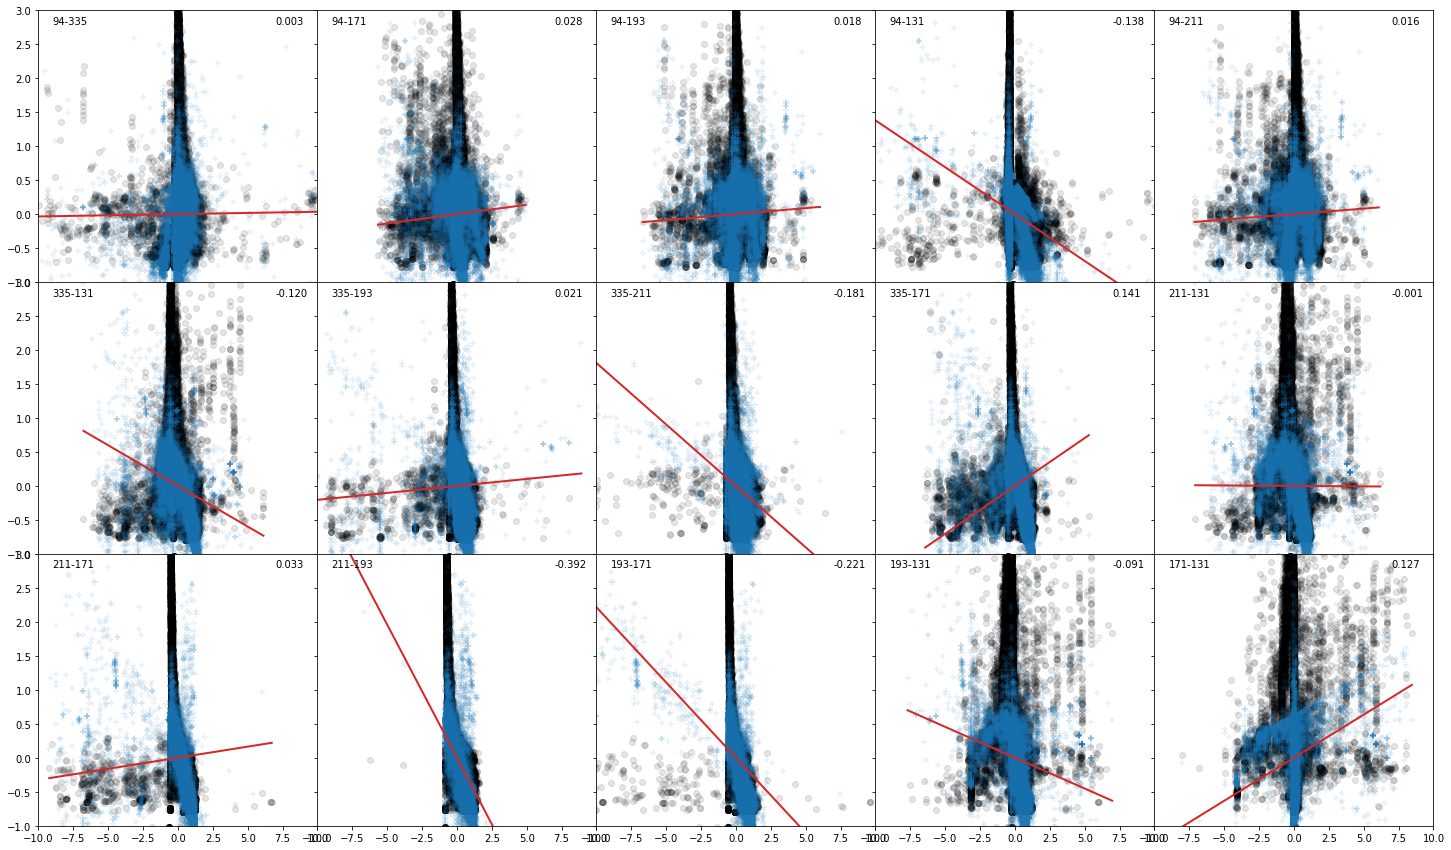

In [112]:
fig,axes = plt.subplots(3,5,figsize=(25,15),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
for i,cp in enumerate(channel_pairs):
    ax = axes.flatten()[i]
    r2 = r2_score(Y_test,Y_pred)
    ax.scatter(X_test[:,i], Y_test[:],alpha=0.1,color='k')
    ax.scatter(X_test[:,i],Y_pred,alpha=0.1,color='C0',marker='+',)
    x_ordered = np.sort(X_test[:,i])
    ax.plot(x_ordered,reg.coef_[i]*x_ordered + reg.intercept_,color='C3',lw=2)
    ax.text(-9,2.8,'{}-{}'.format(*cp))
    ax.text(7,2.8,f'{reg.coef_[i]:.3f}')
ax.set_xlim(-10,10)
ax.set_ylim(-1,3)

Text(7,2.8,'-0.723')

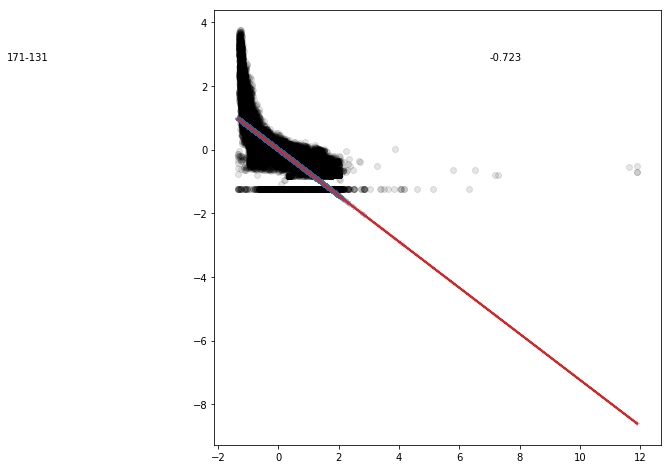

In [114]:
xgt0 = X['low'][:,10]
ygt0 = Y['low'][xgt0 > 0]
xgt0 = xgt0[xgt0>0]
xgt0 = xgt0[:,np.newaxis]
X_scaled = scale(xgt0, axis=0, with_mean=True, with_std=True,)
Y_scaled = scale(ygt0, axis=0, with_mean=True, with_std=True)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33)
reg = LinearRegression()
reg.fit(X_train,Y_train)
Y_pred = reg.predict(X_test)
fig = plt.figure(figsize=(8,8),)
ax = fig.gca()
ax.scatter(X_test, Y_test,alpha=0.1,color='k')
ax.scatter(X_test,Y_pred,alpha=0.1,color='C0',marker='+',)
x_ordered = np.sort(X_test)
ax.plot(x_ordered,reg.coef_*x_ordered + reg.intercept_,color='C3',lw=2)
ax.text(-9,2.8,'{}-{}'.format(*cp))
ax.text(7,2.8,f'{reg.coef_[0]:.3f}')
#ax.set_xlim(-10,10)
#ax.set_ylim(-1,3)